# Boundary to field inference with hypernetworks

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

plt.style.use(["science", "ieee"])

## Example of potential and field contribution from boundary mode ('source')

In [9]:
def mode(theta, n=1):
    return jnp.sin(n * theta)


def sph(x, y):
    return jnp.sqrt(x**2 + y**2), jnp.arctan2(y, x)


def cart(R, theta):
    return R * jnp.sin(theta), R * jnp.cos(theta)


@jax.jit
def boundary(n, theta, R=1.0):
    x, y = cart(R, theta)
    z = jax.vmap(mode, in_axes=(0, None))(theta, n)
    return x, y, z


@jax.jit
def potential(x, y, n):
    r, theta = sph(x, y)
    return jnp.sin(n * theta) * r**n


@jax.jit
def field(x, y, n):
    return jax.grad(potential, argnums=(0, 1))(x, y, n)

In [14]:
n = 8
res = 200
theta = jnp.linspace(0, 2 * jnp.pi, res * res)
dx, dy, dz = boundary(n, theta=theta)
x, y = jnp.meshgrid(jnp.linspace(-1, 1, res), jnp.linspace(-1, 1, res))

z = jax.vmap(jax.vmap(potential, in_axes=(0, 0, None)), in_axes=(1, 1, None))(x, y, n)
Bx, By = jax.vmap(jax.vmap(field, in_axes=(0, 0, None)), in_axes=(1, 1, None))(x, y, n)
x, y, z, Bx, By = np.array(x), np.array(y), np.array(z), np.array(Bx), np.array(By)

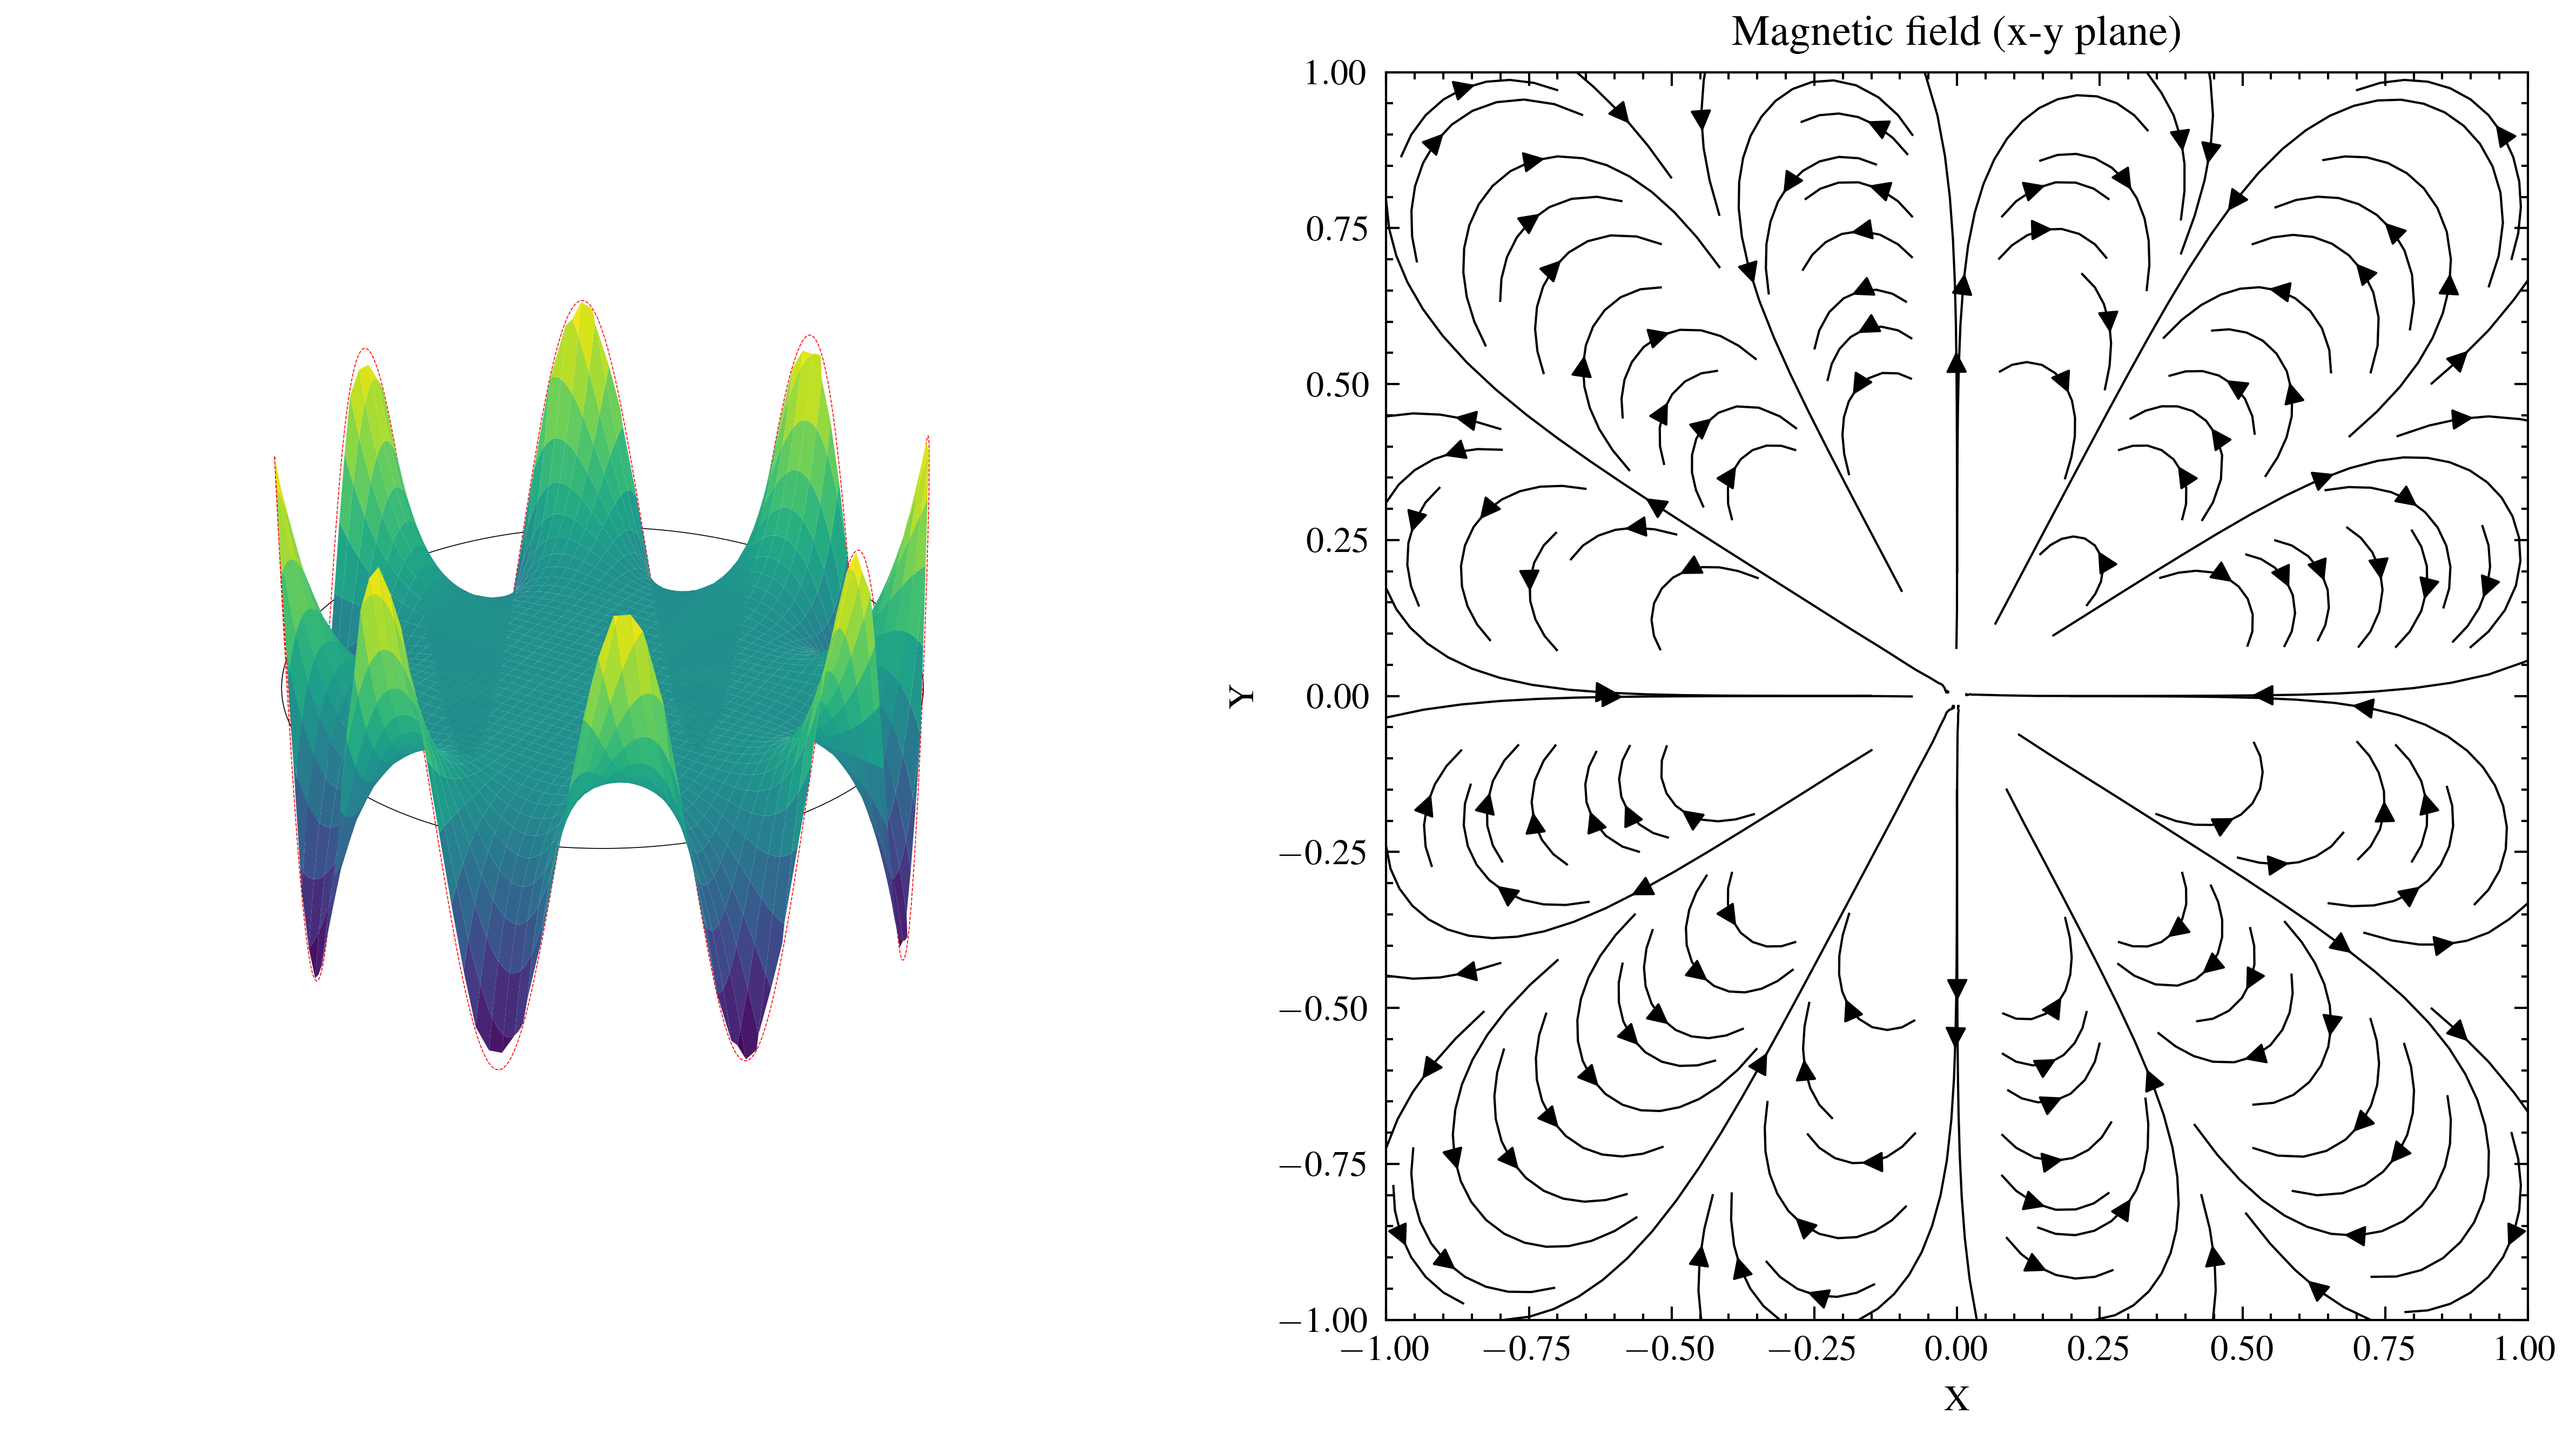

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")

# Prevent surface cells outside the radius from being plotted
z[np.sqrt(x**2 + y**2) >= 1.0] = np.nan
ax.plot_surface(x, y, z, cmap="viridis", edgecolor="none")
ax.axis("off")  # Hide the background 3D axis lines

# Plot the reference circle at r = 1
ax.plot(dx, dy, np.zeros_like(dx), color="black", linewidth=0.2)

# Plot the Dircihlet boundary condition
ax.plot(dx, dy, dz, color="red", linewidth=0.2)

# Associated magnetic field
ax2 = fig.add_subplot(122)
ax2.streamplot(x, y, Bx, By, color="black", linewidth=0.5)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_title("Magnetic field (x-y plane)")

plt.show()

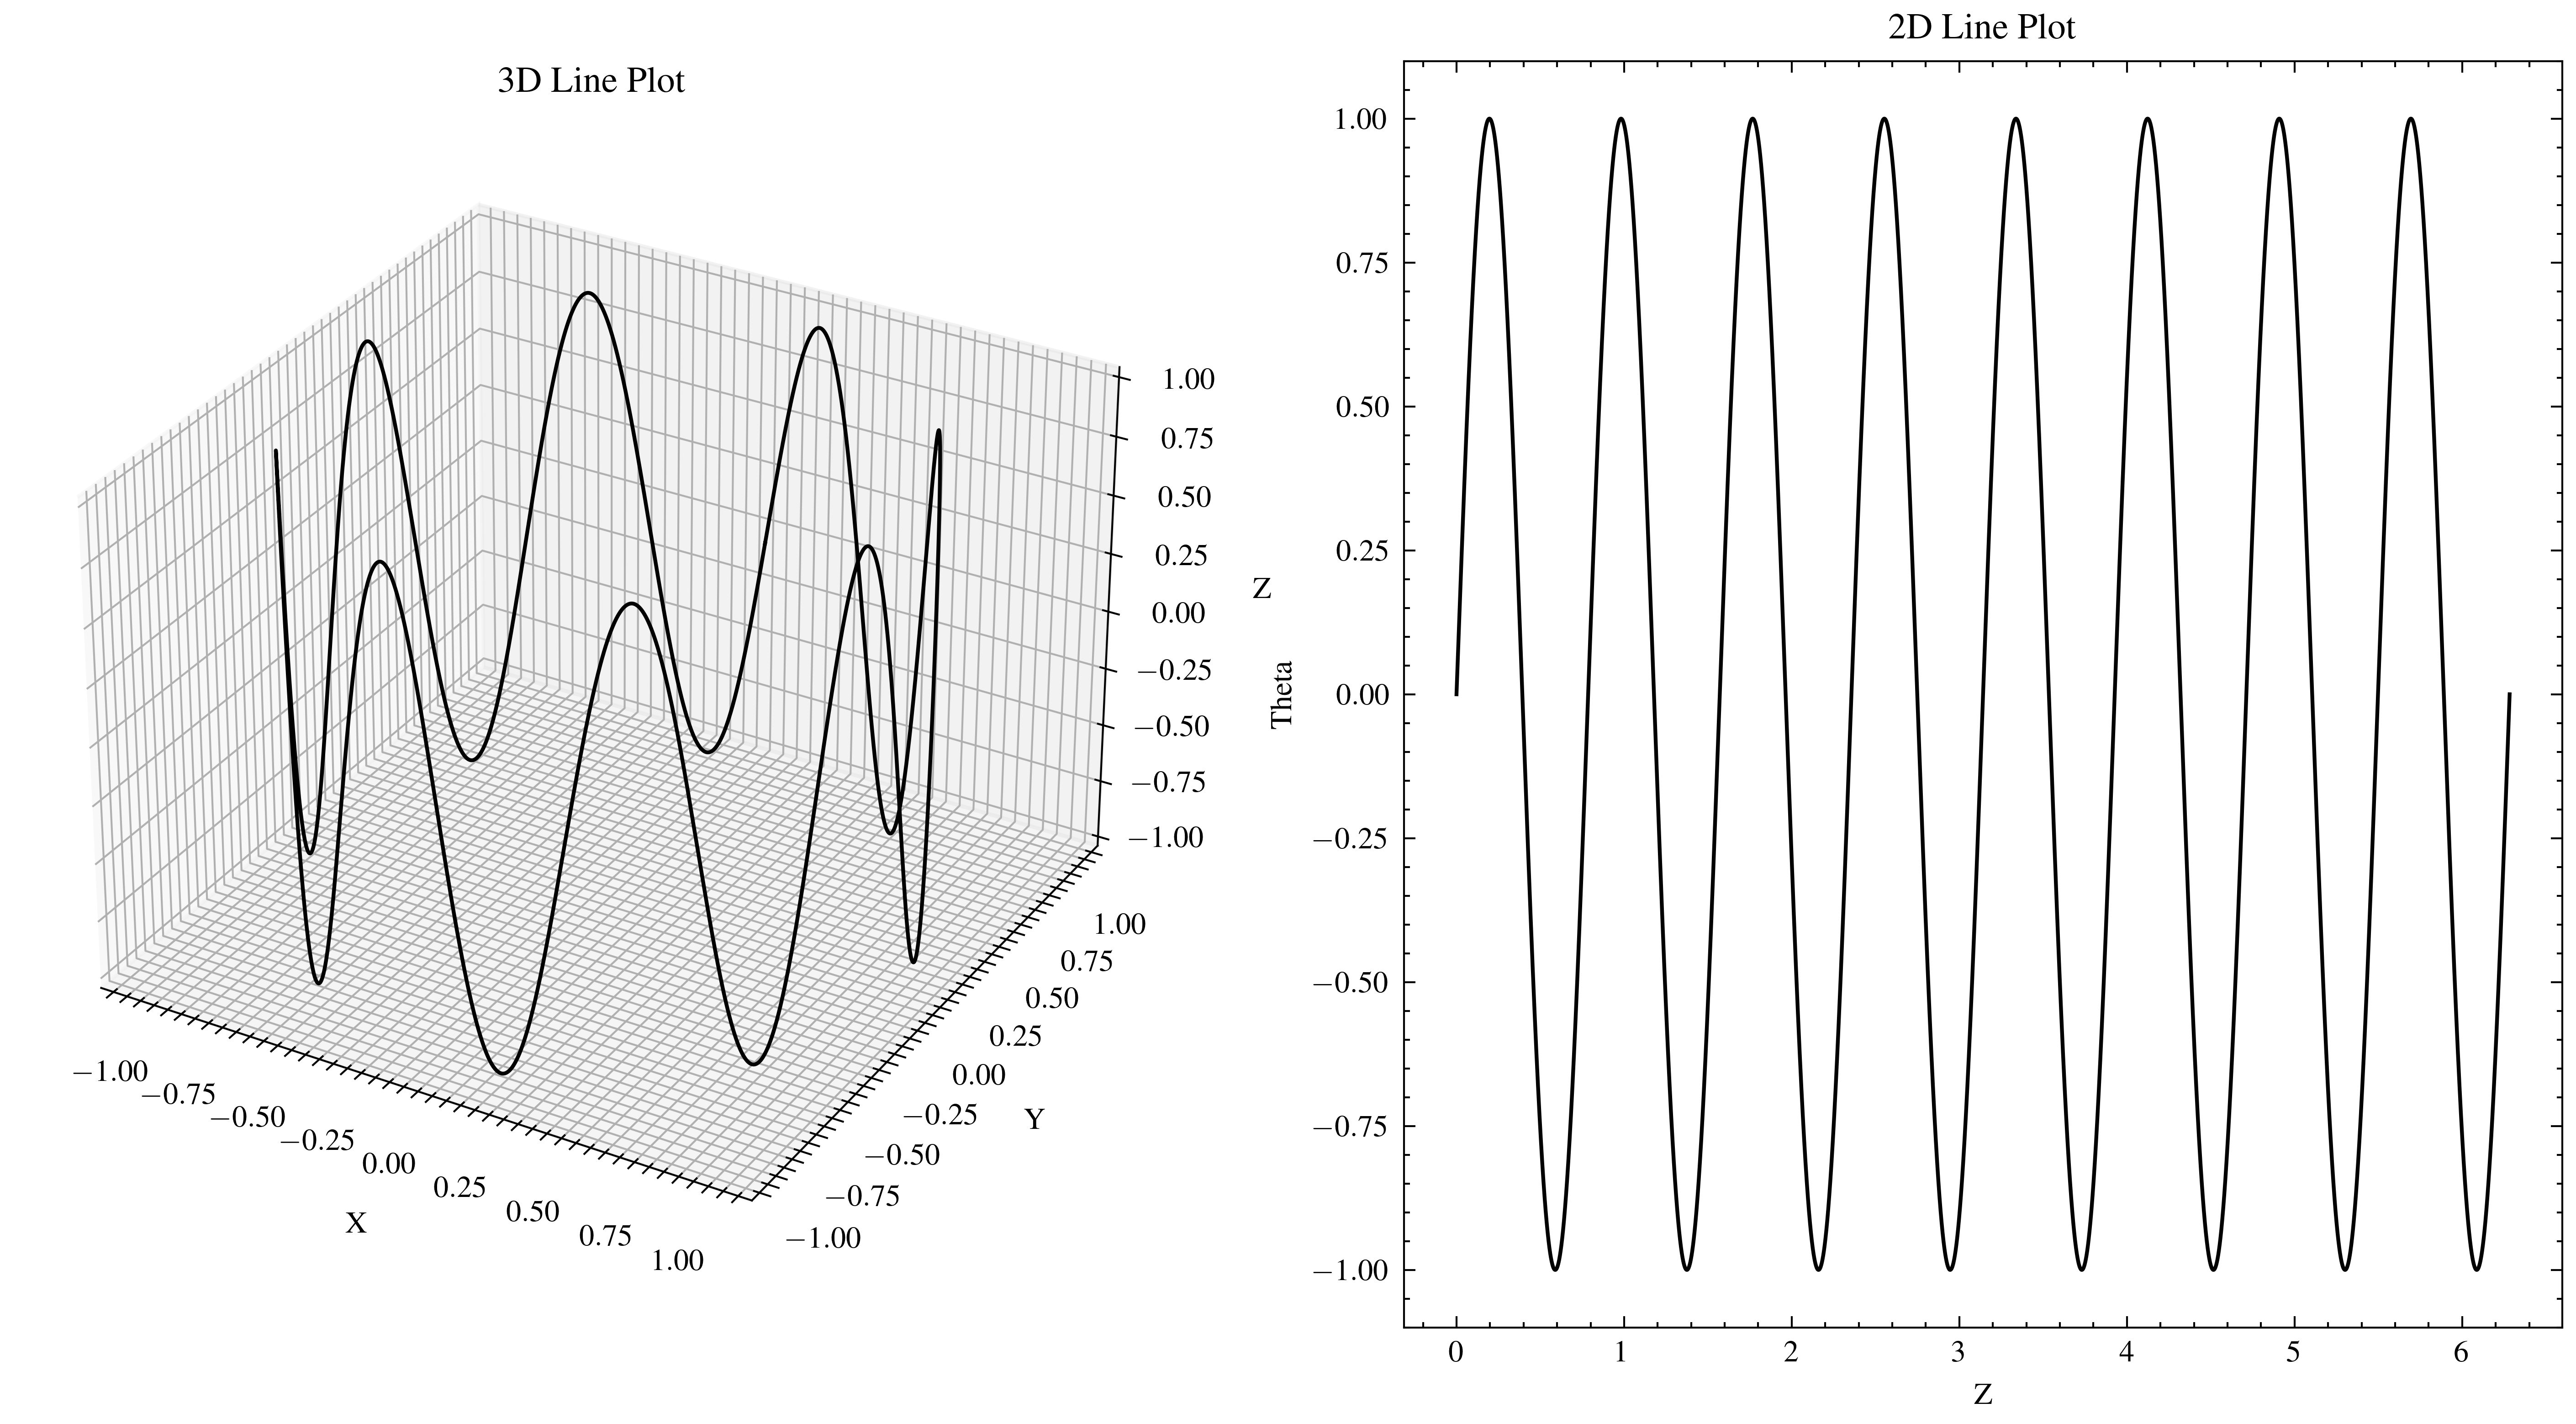

In [16]:
fig = plt.figure(figsize=(12, 6))

# Left subplot: 3D line plot
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(dx, dy, dz)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_title("3D Line Plot")

# Right subplot: 2D line plot
ax2 = fig.add_subplot(122)
ax2.plot(theta, dz)
ax2.set_xlabel("Z")
ax2.set_ylabel("Theta")
ax2.set_title("2D Line Plot")

# plt.tight_layout()
plt.show()

## PyVista interactive plotting

In [ ]:
import numpy as np
import pyvista as pv

# Create a PyVista mesh
points = np.array(jnp.column_stack((dx, dy, dz)))
spline = pv.Spline(points, 1000)
spline.plot(render_lines_as_tubes=True, line_width=10)

# p = pv.Plotter(notebook=True)  # type: ignore
# p.add_mesh(spline, render_lines_as_tubes=True, line_width=10)
# p.show_bounds()
# p.show_axes()
# p.camera_position = "xz"
# p.show()